# DIFUSIÓN DEL CORONAVIRUS EN ESPAÑA:

## (3ª predicción: corrección sobre 2ª con modelo de orden 2)

## 0. INTRODUCCIÓN

Si se quieren ver directamente los resultados de los cálculos, y el pronóstico para los próximos 5 días, pinchar <a href='#a1'>**--> aquí**</a>.

Este es un pequeño ejercicio de extrapolación para la curva de contagios del coronavirus en España.

Como fuente de los datos, a falta de una mejor, se toman los volcados en la siguiente página:

https://www.rtve.es/noticias/20200316/mapa-del-coronavirus-espana/2004681.shtml

Que recoge los datos que vuelca el Ministerio de Sanidad español. La hora de los contagios en el día de dicho informe puede variar, por lo que la diferencia entre un día y otro puede ser mayor o menor de 24 horas, pero a priori se asumirá que la hora del informe de todos los días es la misma, por falta de referencias.

El modelo que emplearemos no será más que una sencilla aproximación por una exponencial, no se empleará el modelo SIR como primera aproximación, aunque este es sólo ligeramente más complejo.

Un modelo de contagio (no asumiendo que cada persona ya contagiada no podría volver a ser contagiada, o asumiendo que la fracción de la población contagiada aún es lo suficientemente baja como para despreciar dichos efectos, lo que es válido para el comienzo de la progresión de la pandemia) respondería a una ecuación diferencial del estilo de:

$y' = c y$

Cuya solución es de la forma:

$ y = K e^{c x}$

O, lo que es lo mismo:

$ y = H A^{b x}$

Donde, para que ambas expresiones sean la misma, tendremos que:

$b = \frac{K}{H \cdot ln(A)} c$

Por lo tanto, tomando logaritmos tendremos:

$ ln(y) = c x + K = b \cdot ln(A) x + H$

En donde tendremos ya una relación lineal.

Nuestro enfoque, por lo tanto, será el de calcular los coeficientes de esta recta.

In [123]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [124]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)

datos.head()

,CONTAGIOS,MUERTOS
FECHA,,
2020-02-12,2,0
2020-02-25,3,0
2020-02-26,7,0
2020-02-27,16,0
2020-02-28,31,0


In [125]:
datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

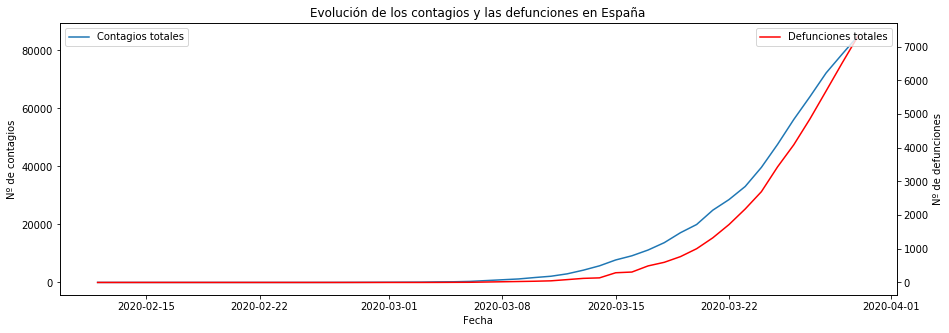

In [126]:
contagios = pd.DataFrame(datos[['CONTAGIOS', 'DIFER_DIAS']])
muertos = pd.DataFrame(datos[['MUERTOS', 'DIFER_DIAS']])

fig, ax1 = plt.subplots(figsize=(15,5))

plt.title('Evolución de los contagios y las defunciones en España')

ax1.plot(contagios.reset_index()['FECHA'], contagios['CONTAGIOS'], '-');
ax1.legend(['Contagios totales'])
ax1.set_ylabel("Nº de contagios")
ax1.set_xlabel("Fecha")

ax2 = ax1.twinx()

ax2.plot(muertos.reset_index()['FECHA'], muertos['MUERTOS'], '-', color='r')
ax2.legend(['Defunciones totales'], loc = 1)
ax2.set_ylabel("Nº de defunciones");

Comparación entre la evolución de los contagios y los muertos, donde puede obsservarse el comportamiento comparado de ambas gráficas, y el retardo existente entre la evolución de los muertos por la infección y el número de infectados:

Nótese cómo la pendiente de la gráfica de la evolución del número de muertos es mucho más empinada que la del número de contagiados.

Queremos analizar ahora el decalaje existente entre ambas series. Para ello emplearemos dos métodos:

En el primero haremos lo más evidente, que sería buscar, para cada día de la serie de los contagios, el día con un valor equivalente en la serie de defunciones y calcularemos su diferencia.

Para encontrar dicho día equivalente lo que haremos es buscar, por un lado, el primer día de la serie de defunciones cuyo valor es superior al buscado, y por otro, el último día que es inferior, y tomaremos la media de ambos valores (debido que en algunos casos la diferencia entre ambos valores es relativamente elevada):

In [127]:
storage = np.array([])

for element in contagios.iterrows():

    try:
        
       for_mean = (muertos[muertos['MUERTOS'] > element[1][0]].index[0] - element[0]).days
       for_mean += (muertos[muertos['MUERTOS'] < element[1][0]].index[-1] - element[0]).days
        
       storage = np.append(storage, for_mean/2)
        
    except IndexError:
        continue
        
storage.mean()

11.733333333333333

Podemos observar que el valor obtenido para el decalaje es de unos 11 días.

Vamos a contrastar esto con un segundo método:
    
En este segundo método lo que haremos será desplazar la serie de contagios 1, 2, 3, ... n días (hasta 16) y comparar la diferencia relativa de ambas curvas, mediante un error absoluto medio.

El desplazamiento que obtenga menor diferencia relativa será el que mejor coloque la curva de decesos sobre la de contagios:

In [128]:
# Creamos un índice completo para nuestras fechas de interés:

index_for_merge = pd.DataFrame(index = pd.date_range(pd.to_datetime('2020-02-12', format = '%Y-%m-%d'), pd.to_datetime('2020-03-24', format = '%Y-%m-%d')))

# Creamos un dataframe con todas las fechas para ambas series, y rellenamos los NaN con el último dato inmediatamente anterior:

contagios_full_index = pd.merge(index_for_merge, contagios, left_index= True, right_index= True, how='left') 
contagios_full_index.fillna(method = 'ffill', inplace = True)

muertos_full_index = pd.merge(index_for_merge, muertos, left_index= True, right_index= True, how='left') 
muertos_full_index.fillna(method = 'ffill', inplace = True)

# Calculamos la diferencia relativa entre ambas curvas:

for x in range(1,16):

    print(x, " días de decalaje, error: ", 
          (abs(contagios_full_index['CONTAGIOS'] - muertos_full_index['MUERTOS'].shift(-x))/
              (contagios_full_index['CONTAGIOS'] + muertos_full_index['MUERTOS'].shift(-x))).mean())

1  días de decalaje, error:  0.957257505630955
2  días de decalaje, error:  0.9427330383355891
3  días de decalaje, error:  0.9221783999780573
4  días de decalaje, error:  0.8927108042501711
5  días de decalaje, error:  0.8566660695801454
6  días de decalaje, error:  0.8096363740070792
7  días de decalaje, error:  0.7352545221102122
8  días de decalaje, error:  0.6417626358820625
9  días de decalaje, error:  0.54267011034905
10  días de decalaje, error:  0.4911488653733783
11  días de decalaje, error:  0.4787775891750178
12  días de decalaje, error:  0.5233639072253186
13  días de decalaje, error:  0.6004964213156125
14  días de decalaje, error:  0.6663521809580741
15  días de decalaje, error:  0.7189359190126424


Como podemos observar que el error relativo medio mínimo se encuentra de nuevo en los 11 días, un fuerte indicador de que el decalaje entre ambas curvas es esta cantidad.

Finalmente, si representamos dicho decalaje de 11 días podemos ver cómo la curva de defunciones sigue el comportamiento de la curva de contagios casi a la perfección:

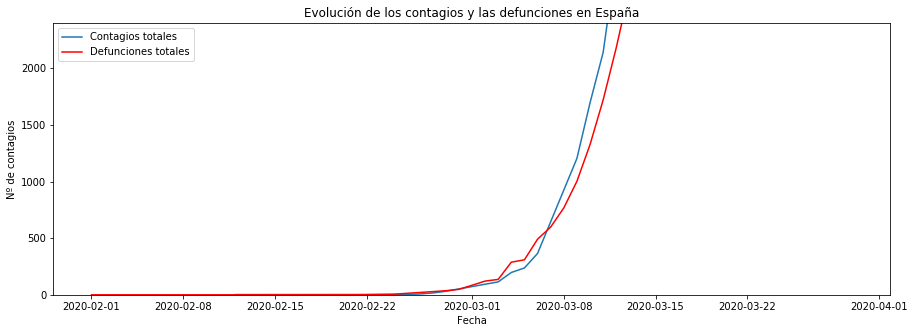

In [129]:
fig, ax1 = plt.subplots(figsize=(15,5))

plt.title('Evolución de los contagios y las defunciones en España')

ax1.set_ylim(ymax = 2400)

ax1.plot(contagios.reset_index()['FECHA'], contagios['CONTAGIOS'], '-')
ax1.plot(muertos.reset_index()['FECHA'] - datetime.timedelta(days = 11), muertos['MUERTOS'], '-', color='r')

ax1.legend(['Contagios totales', 'Defunciones totales'], loc = 2)
ax1.set_ylabel("Nº de contagios")
ax1.set_xlabel("Fecha");

## 1. CONTAGIOS

**Paso 1:**

**Comprobaciones sobre la serie:**

Examinamos primero los datos de los contagios:

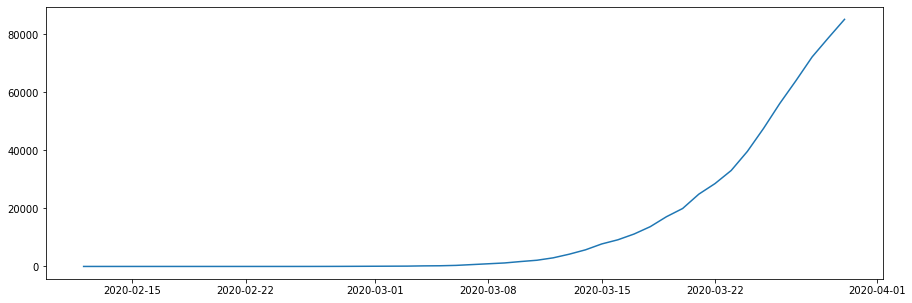

In [130]:
plt.figure(figsize=(15,5))
plt.plot(contagios.index, contagios['CONTAGIOS'], '-');

Como podemos ver, tenemos una curva monótona creciente que, aparentemente, parece seguir la forma de una exponencial.

Examinamos ahora la serie en diferencias. Como se sabe, si la serie original sigue una exponencial, la serie en diferencias debería seguir también una exponencial:

In [131]:
# Sumamos 1 por cuestiones de estabilidad numérica a la hora de tomar logaritmos posteriormente:
contagios['DIFER'] = contagios['CONTAGIOS'].diff(1).fillna(2)/contagios['DIFER_DIAS']

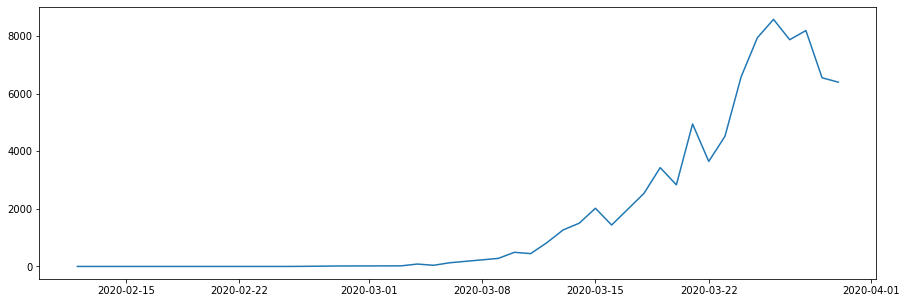

In [132]:
plt.figure(figsize=(15,5))
plt.plot(contagios['DIFER'], '-');

Vemos un primer pico en la series de los contagios, en el entorno del día 15 de marzo.

Su aparición (y tal vez la de los siguientes) puede explicarse por lo siguiente:

https://elpais.com/sociedad/2020-03-15/cataluna-y-madrid-dejan-de-hacer-pruebas-a-los-casos-leves.html

https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-test-solo-pacientes-hospitalizados-personal-esencial-8816

https://www.noticiasdenavarra.com/actualidad/sociedad/2020/03/16/navarra-cambia-protocolo-deteccion-coronavirus/1031165.html

https://www.elmundo.es/ciencia-y-salud/salud/2020/03/13/5e6b4230fdddff878c8b4624.html

Al cambiar los criterios con los que hacer las pruebas, se están dejando fuera, a partir del día 15, a un gran número de casos que habrían dado positivo según los criterios antiguos, pero que ahora se dejan fuera de los casos confirmados, según los nuevos.

Si la decisión se trata de criterios de economía médica, intereses políticos o una mezcla de ambas, sólo puedo dejarlo a juicio del lector.

A pesar de ello se puede ver que nada puede hacer ese cambio de criterio frente al contagio exponencial.

Para nuestro esutio tomaremos primero solamente la primera parte de la curva, donde no se ha modificado aún el criterio para la realización de las pruebas, para no adulterar la evolución.

In [133]:
contagios['LN_CONTAGIOS'] = contagios['CONTAGIOS'].apply(lambda x: np.log(x) if x>0 else 0)
# Añadimos +1 por criterios de estabilidad con el logaritmo:
contagios['LN_DIFER'] = contagios['DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)

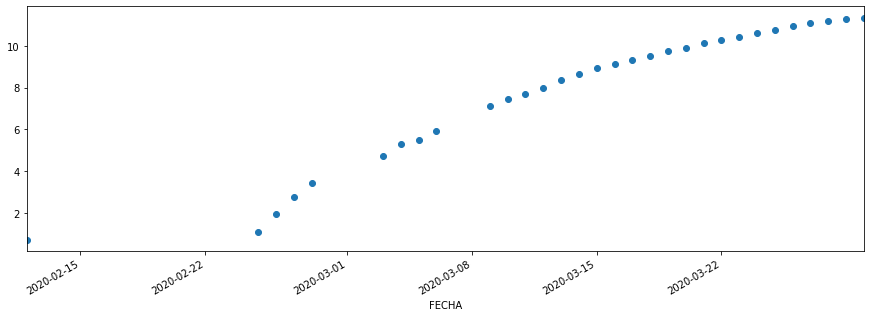

In [134]:
contagios['LN_CONTAGIOS'].plot(figsize=(15,5), style = 'o')

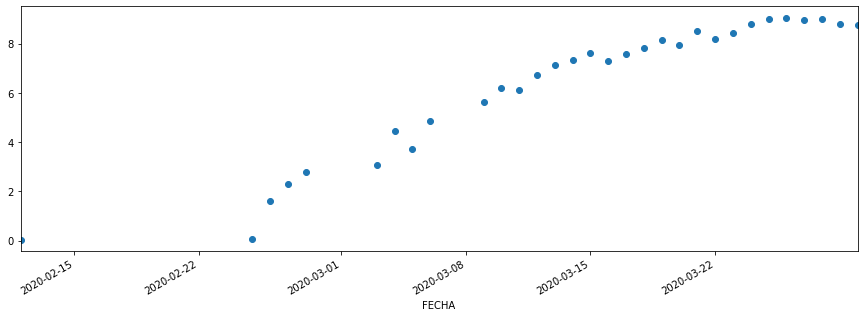

In [135]:
contagios['LN_DIFER'].plot(figsize=(15,5), style = 'o')

Como podemos ver, ante nosotros no tenemos una recta, sino más bien un comportamiento más bien parabólico, característico de funciones como una raíz cuadrada.

Esto son buenas noticias, porque nos indica que el virus no se está propagando siguiendo una exponencial, sino más bien una exponencial algo amortiguada.

También podemos observar un comportamiento errático en la serie de las diferencias de los logaritmos de los contagios diarios.

Vamos a examinar la serie de sus diferencias. Si el proceso fuese exponencial, estas deberían ser constantes:

0.25630518425567744

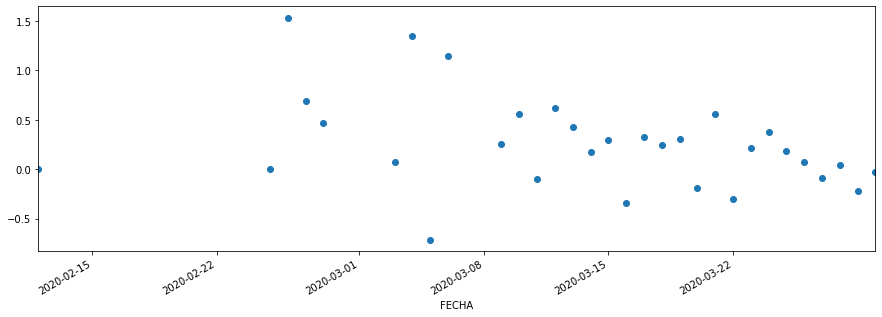

In [136]:
contagios['LN_DIFER_2']  = contagios['LN_DIFER'].diff(1).fillna(0)/contagios['DIFER_DIAS']
contagios['LN_DIFER_2'].plot(figsize=(15,5), style = 'o')
contagios['LN_DIFER_2'].mean()

Podemos observar un comportamiento claramente errático, con una varianza elevada y valores oscilando alrededor de una zona central, pero con una amplia dispersión.

Esto puede deberse a muchos factores relacionados con la toma de datos, con el hecho de que las horas de los informes emitidos por el Ministerio de Sanidad no siempre coincidan y con que la afluencia de la gente a hacerse las pruebas, así como los criterios para hacer las mismas han ido evolucionando según progresaba la enfermedad.

(array([ 1.,  9., 12.,  6.,  1.,  2.]),
 array([-0.71724473, -0.34181562,  0.03361349,  0.4090426 ,  0.78447172,
         1.15990083,  1.53532994]),
 <a list of 6 Patch objects>)

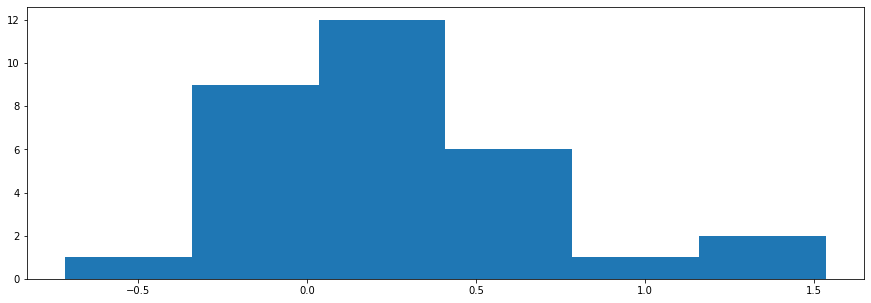

In [137]:
plt.figure(figsize=(15,5))
plt.hist(contagios['LN_DIFER_2'], bins = 6)

Como vemos, el máximo central se presenta, con 8 valores, para la zona entre 0,04 y 0,784.

In [138]:
contagios['LN_CONTAGIOS_DIFER'] = contagios['LN_CONTAGIOS'].diff(1).fillna(0)/contagios['DIFER_DIAS']

### MODELO FINAL:

En los scripts anteriores hemos intentado realizar ajustes con modelos lineales, intentando linealizar la curva parabólica de los contagios.

Vamos ahora intentar su ajuste con modelos de orden 2, sin "aplanarla" elevándola a un factor.

Reajustaremos nuestras funciones convenientemente para ello, y lanzaremos modelos de orden 2.

Una vez tengamos nuestro modelo calcularemos el error que nos devuelve nuestro ajuste y haremos predicciones:

In [139]:
def cols_para_calculos(df: 'DataFrame', dates_in_index = True):
    
    if dates_in_index:
        day_range = (df.index - df.index[0]).days
        df.loc[:,'FECHA'] = day_range
    else:
        df['FECHA'] =(df.index - df.index[0])
    
    return df

In [140]:
contagios.head()

,CONTAGIOS,DIFER_DIAS,DIFER,LN_CONTAGIOS,LN_DIFER,LN_DIFER_2,LN_CONTAGIOS_DIFER
FECHA,,,,,,,
2020-02-12,2,100,0.020000,0.693147,0.019803,0.000000,0.000000
2020-02-25,3,13,0.076923,1.098612,0.074108,0.004177,0.031190
2020-02-26,7,1,4.000000,1.945910,1.609438,1.535330,0.847298
2020-02-27,16,1,9.000000,2.772589,2.302585,0.693147,0.826679
2020-02-28,31,1,15.000000,3.433987,2.772589,0.470004,0.661398


In [141]:
contagios.drop(contagios.index[[0]], inplace = True)
df_contagios_pred = contagios[['CONTAGIOS', 'DIFER_DIAS', 'LN_CONTAGIOS', 'DIFER', 'LN_DIFER']].copy()
df_contagios_pred = cols_para_calculos(df_contagios_pred)

In [142]:
def ajuste_min_cuadrados(serie_x: 'Series', serie_y: 'Series', col: 'string'):
    
    
    # Añadimos en el polyfit unos pesos exponenciales sobre el factor de corrección, 
    # para que el modelo ajuste el peso de los errores según los que tendrían con la distribución original 
    # del valor en y, y no la propia recta:
    
    x_range = serie_x
    coefs = np.polyfit(np.array(x_range), np.array(serie_y) , deg = 2, w=np.exp(serie_y))

    arr_pred =  x_range**2 * coefs[0] + x_range * coefs[1] + coefs[2]

    df_pred = pd.DataFrame(arr_pred)
    df_pred.rename({'FECHA':'PRED'}, axis=1, inplace = True)
    df_pred['SERIE'] = serie_y
    
    
    df_pred.plot(figsize=(18,5))
    print(df_pred.corr())
    
    df_pred[col] = np.round(np.exp(df_pred['PRED']).fillna(1))

    return df_pred, coefs

           PRED     SERIE
PRED   1.000000  0.998374
SERIE  0.998374  1.000000


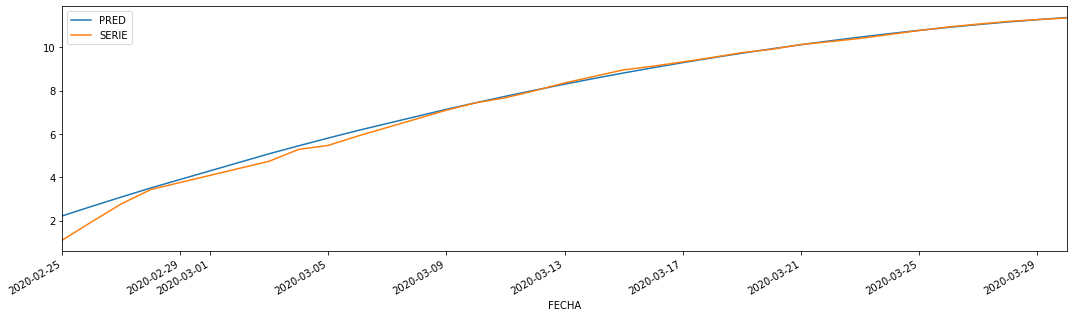

In [143]:
new_contagios_prediction, coefs = ajuste_min_cuadrados(df_contagios_pred['FECHA'],
                                                       df_contagios_pred['LN_CONTAGIOS'],
                                                       'PRED_CONTAGIOS')

In [144]:
df_contagios_pred['PRED_CONTAGIOS'] = new_contagios_prediction['PRED_CONTAGIOS']
df_contagios_pred['ERROR_ABS'] = abs(df_contagios_pred['PRED_CONTAGIOS'] - df_contagios_pred['CONTAGIOS'])
df_contagios_pred['ERROR_REL'] = (abs(df_contagios_pred['PRED_CONTAGIOS'] - df_contagios_pred['CONTAGIOS'])/df_contagios_pred['CONTAGIOS']).fillna(0)
df_contagios_pred.loc[df_contagios_pred.index[1]:,'ERROR_REL'].mean()

0.12251758300597576

In [145]:
df_contagios_pred.loc[pd.to_datetime('2020-03-15'):,'ERROR_REL'].mean()

0.03358470585450067

In [146]:
def prediccion(day_num_of_reference, date_of_reference, coeficientes, entre=(1,6)):    

    x_range_ext = np.array(range(day_num_of_reference + entre[0], day_num_of_reference + entre[1]))
    index = [date_of_reference + datetime.timedelta(int(x)) for x in x_range_ext]
    arr_pred = x_range_ext**2 * coeficientes[0] + x_range_ext * coeficientes[1] + coeficientes[2]

    arr_pred = np.round(np.exp(arr_pred))
    arr_pred = pd.DataFrame(arr_pred, columns = ['PRED'], index = index)
    return arr_pred

In [147]:
day_num_of_reference = df_contagios_pred['FECHA'][-1]
date_of_reference = df_contagios_pred.index[0]
arr_contagios_pred = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_contagios_pred

,PRED
2020-03-31,94708.0
2020-04-01,102301.0
2020-04-02,109362.0
2020-04-03,115702.0
2020-04-04,121144.0


In [148]:
arr_contagios_pred.diff().fillna(arr_contagios_pred.iloc[0, 0] - df_contagios_pred.loc[df_contagios_pred.index[-1], 'CONTAGIOS'])

,PRED
2020-03-31,9513.0
2020-04-01,7593.0
2020-04-02,7061.0
2020-04-03,6340.0
2020-04-04,5442.0


Podemos ver que tenemos un primer dato de contagios diarios muy poco creíble.

Resulta muy sospechoso que tengamos un valor de contagios de 9500 para el día 31 de marzo, cuando los días anterior y posterior presentarían valores en el orden de los 6000-7000.

El problema es que el ajuste polinómico nos devuelve un valor ya algo desviado respecto al real actual, como podemos observar a continuación:

In [149]:
arr_contagios_temp = prediccion(day_num_of_reference, date_of_reference, coefs, entre = (0,6))
desfase = arr_contagios_temp.iloc[0,0] - df_contagios_pred.iloc[-1,0]
desfase

1577.0

Una forma de mejorar nuestras predicciones es corregir este desfase de nuestros resultados (puesto que es un desfase que arrastra el método pero que sabemos que ya no es real):

In [150]:
arr_contagios_pred = arr_contagios_pred - desfase

In [151]:
arr_contagios_pred

,PRED
2020-03-31,93131.0
2020-04-01,100724.0
2020-04-02,107785.0
2020-04-03,114125.0
2020-04-04,119567.0


Y ahora ya sí:

In [152]:
arr_contagios_pred.diff().fillna(arr_contagios_pred.iloc[0, 0] - df_contagios_pred.loc[df_contagios_pred.index[-1], 'CONTAGIOS'])

,PRED
2020-03-31,7936.0
2020-04-01,7593.0
2020-04-02,7061.0
2020-04-03,6340.0
2020-04-04,5442.0


Vamos por lo tanto a aplicar el mismo método a la serie de contagios diarios, y luego hacer su suma agregada para obtener los valores totales:

           PRED     SERIE
PRED   1.000000  0.989484
SERIE  0.989484  1.000000


,PRED
2020-03-31,6813.0
2020-04-01,6286.0
2020-04-02,5680.0
2020-04-03,5025.0
2020-04-04,4354.0


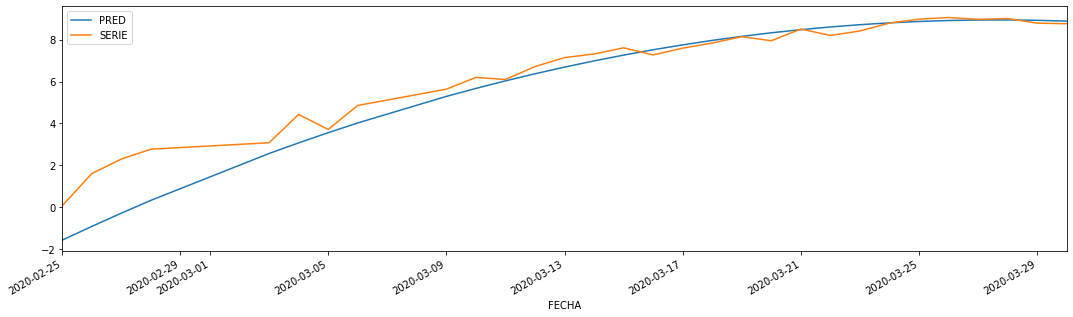

In [28]:
new_contagios_prediction_2, coefs = ajuste_min_cuadrados(df_contagios_pred['FECHA'], 
                                                       df_contagios_pred['LN_DIFER'], 
                                                       'PRED_CONT_DIARIOS')

df_contagios_pred['PRED_CONT_DIARIOS'] = new_contagios_prediction_2['PRED_CONT_DIARIOS']
df_contagios_pred['ERROR_DIFER_ABS'] = abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])
df_contagios_pred['ERROR_DIFER_REL'] = (abs(df_contagios_pred['PRED_CONT_DIARIOS'] - df_contagios_pred['DIFER'])/df_contagios_pred['DIFER']).fillna(0)

arr_contagios_diarios_pred = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_contagios_diarios_pred

In [30]:
df_contagios_pred.loc[pd.to_datetime('2020-03-15'):,'ERROR_REL'].mean()

0.03358470585450067

In [46]:
arr_contagios_pred_2 = arr_contagios_diarios_pred.cumsum() + df_contagios_pred.loc[df_contagios_pred.index[-1],'CONTAGIOS']
arr_contagios_pred_2

,PRED
2020-03-31,92008.0
2020-04-01,98294.0
2020-04-02,103974.0
2020-04-03,108999.0
2020-04-04,113353.0


## 2. MUERTOS

Pasamos ahora a comprobar los de los muertos. Representamos a continuación la curva del total acumulado de muertos en España:

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(muertos['MUERTOS'], '-', color='orange');

A continuación, la evolución del ratio de muertos a infectados:

In [ ]:
datos['ratio'] = datos['MUERTOS']/datos['CONTAGIOS']
datos['ratio'].plot(figsize=(15,5));

Y el ratio de muertes provocadas por la enfermedad cada día:

In [ ]:
muertos['MUERTOS_DIARIOS'] = muertos['MUERTOS'].diff().fillna(0)/muertos['DIFER_DIAS']
muertos['MUERTOS_DIARIOS'].plot(figsize = (15,5))

Y, como en el caso de los contagios, la forma que presenta el logaritmo de las muertes acumuladas por la enfermedad, día tras día:

In [ ]:
muertos['LN_MUERTOS'] = muertos['MUERTOS'].apply(lambda x: 0 if x == 0 else np.log(x))
muertos[muertos['LN_MUERTOS'] != 0]['LN_MUERTOS'].plot(figsize=(15,5));

Y pasamos ya al modelo:

In [ ]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

In [ ]:
df_muertos_pred = muertos.loc[muertos['MUERTOS'] != 0, ['MUERTOS', 'DIFER_DIAS', 'LN_MUERTOS']].copy()

df_muertos_pred = cols_para_calculos(df_muertos_pred)

other_prediction, coefs = ajuste_min_cuadrados(df_muertos_pred['FECHA'], df_muertos_pred['LN_MUERTOS'], 'PRED_MUERTES')

Ahora que ya tenemos las predicciones, deshacemos:

In [ ]:
other_prediction['FECHA'] = muertos[muertos['MUERTOS'] != 0].index
other_prediction.set_index('FECHA', inplace = True)

Y, finalmente, tendremos ya el método ajustado y podemos insertarlo en nuestro DataFrame y calcular errores:

In [ ]:
muertos['PRED'] = other_prediction['PRED_MUERTES']
muertos['PRED'].fillna(0, inplace = True)
muertos['ERROR_ABS'] = abs(muertos['PRED'] - muertos['MUERTOS'])
muertos['ERROR_REL'] = (abs(muertos['PRED'] - muertos['MUERTOS'])/muertos['MUERTOS']).fillna(0)
muertos.tail(10)

Como podemos ver, en este caso el ajuste es muy bueno. Vamos a extrapolar hacia el futuro, para predecir el total de muertos a lo largo de los próximos 5 días:

In [ ]:
day_num_of_reference = df_muertos_pred['FECHA'][-1]
date_of_reference = muertos[muertos['MUERTOS'] != 0].index[0]

arr_muertos_pred = prediccion(day_num_of_reference, date_of_reference, coefs)
arr_muertos_pred

Y, una vez teniendo ya la predicción de los muertos totales, podemos añadir al DataFrame y calcular también la diferencia diaria:

Resaltar que, para el primer valor predicho de muertos diarios, el número puede estar ligeramente sobreestimado por la diferencia de 65 personas existente entre la predicción y el número real de muertos para la fecha del día de hoy (22/03/2020).

El resto de valores sí deberían estar en la línea del comportamiento futuro.

Como se puede ver, la evolución es ciertamente preocupante:

In [ ]:
muertos = muertos.append(arr_muertos_pred, sort = False)
muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'MUERTOS_DIARIOS'] = muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'PRED'].diff()
missing_date = muertos[muertos['MUERTOS_DIARIOS'].isna()].index
muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'MUERTOS_DIARIOS'] = muertos.loc[missing_date, 'PRED'] - muertos['MUERTOS'].shift(1)[missing_date]
muertos.tail(10)

Finalmente, dejamos el error relativo medio:

In [ ]:
muertos.loc[date_of_reference + datetime.timedelta(int(day_num_of_reference-10)):, 'ERROR_REL'].mean()

Como podemos ver, el error relativo cometido en el ajuste en los últimos 10 días con datos es del 1,5%, lo que es un valor aceptable para una primera estimación y da bastante confianza para nuestras estimaciones.

## 3. PREDICCIONES<a id='a1'></a>

Presentamos finalmente las predicciones, de seguir presentando la expansión del virus el comportamiento actual:

**CONTAGIOS (total contagiados)**

In [ ]:
arr_contagios_pred

**MUERTOS (total muertos)**

In [ ]:
arr_muertos_pred